In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import numpy as np
import time
import copy
import os
import re
import math
import datetime
import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)	#Show all rows
pd.set_option('display.max_columns',10)	#Show all cols
pd.set_option('display.max_colwidth', None)	#不要truncate cell

import multiprocessing
print('Number of CPU:',multiprocessing.cpu_count())

#加载dat文件解析函数
from road_log_parser import parse_data

Number of CPU: 128


# Load Window Labels

In [2]:
root=r'../Data/Train/SlicedData/Window_labels'
labels=[]
for date in os.listdir('../Data/Train/SlicedData/ExtractedFeatures'):                        #仅读取已提取特征的日期
    date_path=os.path.join(root,date)
    for file in os.listdir(date_path):
        file_path=os.path.join(date_path,file)
        label=pd.read_csv(file_path)
        label['Date']=date 
        label['File']=file
        labels.append(label)
labels=pd.concat(labels,ignore_index=True)
labels['File']=labels['File'].str[:-4]                            #去掉.csv的后缀名，保持标签数据和无标签数据文件名一致
print(labels['Date'].value_counts())
labels.head()

20230815    24247
20230706    23940
20230821    23721
20230710    14460
20230721    12347
20230713    10172
20230707    10100
20230703     7833
20230809     7310
20230714     4531
20230804     1417
Name: Date, dtype: int64


,StartIndex,EndIndex,Label,Date,File
0,0,600,正常路段,20230707,DataRecordInput_2023077_153007.dat
1,20,620,正常路段,20230707,DataRecordInput_2023077_153007.dat
2,40,640,正常路段,20230707,DataRecordInput_2023077_153007.dat
3,60,660,正常路段,20230707,DataRecordInput_2023077_153007.dat
4,80,680,正常路段,20230707,DataRecordInput_2023077_153007.dat


In [3]:
labels.groupby(['Date','File'])['Label'].value_counts()

Date      File                                 Label           
20230703  DataRecordInput_2023073_140356.dat   正常路段                 226
                                               功能关闭 下桥               24
          DataRecordInput_2023073_140516.dat   正常路段                 176
                                               功能关闭 上桥               24
          DataRecordInput_2023073_140605.dat   正常路段                 164
                                               功能打开  未设置参数   下桥      25
          DataRecordInput_2023073_140712.dat   正常路段                 193
                                               功能打开  未设置参数   上桥      25
          DataRecordInput_2023073_140832.dat   正常路段                 132
                                               功能正常 下桥               24
          DataRecordInput_2023073_140939.dat   正常路段                 164
                                               功能正常 上桥               26
          DataRecordInput_2023073_141030.dat   正常路段                 163


# Load Raw Time Series Data

In [4]:
root=r'../Data/Train/Raw'
data={}
for date in os.listdir(root):
    if '.xlsx' in date or '.ipynb_checkpoints' in date:continue                    #跳过标签文件和临时文件
    date_path=os.path.join(root,date)
    data[date]={}
    for file in tqdm.tqdm(os.listdir(date_path),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        if '.tgz' in file:continue                 #跳过tgz文件
        file_path=os.path.join(date_path,file)
        datum=parse_data(file_path)                #解析.dat文件
        #单个样本内填充缺失
        datum.replace([np.inf,-np.inf],np.nan,inplace=True)
        datum.fillna(method='ffill',inplace=True)
        datum.fillna(method='bfill',inplace=True)
        datum.drop(columns=['TimeStamp'],inplace=True)
        data[date][file]=datum

100%|██████████| 17/17 [00:06<00:00,  2.49it/s]                                                                                                                


In [5]:
print(data['20230707']['DataRecordInput_2023077_153007.dat'].head().shape)
data['20230707']['DataRecordInput_2023077_153007.dat'].head()

(5, 21)


,FrntLeLvl,FrntRiLvl,ReLeLvl,ReRiLvl,WhlSpdFrntLe,WhlSpdFrntRi,WhlSpdReLe,WhlSpdReRi,BdyAz_FL,BdyAz_FR,BdyAz_RL,CDC_BdyPitchA,CDC_BdyPitchRate,CDC_BdyRollA,CDC_BdyRollRate,CDC_BdyAZ,CDC_BdyVZ,EstRdRelDpl_Le,EstRdRelDpl_Ri,VINP_GPSLat_u32,VINP_GPSLong_u32
0,0,-3,1,4,0.0,0.0,0.0,0.0,-0.0028,-0.0028,-0.0028,-0.210022,0.029999,-1.600006,0.0,22.0,1.800049,0,0,3126435,12117239
1,0,-3,1,4,0.0,0.0,0.0,0.0,-0.0028,-0.0028,-0.0028,-0.210022,0.029999,-1.600006,0.0,22.0,1.800049,0,0,3126435,12117239
2,0,-3,1,4,0.0,0.0,0.0,0.0,-0.0028,-0.0028,-0.0028,-0.210022,0.029999,-1.600006,0.0,22.0,1.800049,0,0,3126435,12117239
3,0,-3,1,4,0.0,0.0,0.0,0.0,-0.0028,-0.0028,-0.0028,-0.210022,0.029999,-1.600006,0.0,22.0,1.800049,0,0,3126435,12117239
4,0,-3,1,4,0.0,0.0,0.0,0.0,-0.0028,0.0005,-0.0028,-0.210022,0.029999,-1.600006,0.0,22.0,1.800049,0,0,3126435,12117239


In [6]:
# tmp=data['20230707']['DataRecordInput_2023077_153007.dat']
# for col in tmp.columns:
#     plt.figure(figsize=(10,1))
#     plt.plot(list(range(tmp.shape[0])),tmp[col])
#     plt.title(col)
#     plt.show()

In [22]:
usecols=['FrntLeLvl', 'FrntRiLvl', 'ReLeLvl', 'ReRiLvl', 'WhlSpdFrntLe', 'WhlSpdFrntRi', 'WhlSpdReLe', 'WhlSpdReRi', 'BdyAz_FL', 'BdyAz_FR', 'BdyAz_RL', 'CDC_BdyPitchA', 'CDC_BdyPitchRate', 'CDC_BdyRollA', 'CDC_BdyRollRate', 'CDC_BdyAZ', 'CDC_BdyVZ', 'EstRdRelDpl_Le', 'EstRdRelDpl_Ri', 'VINP_GPSLat_u32', 'VINP_GPSLong_u32']
for col in usecols:
    print('\n',col)
    for date in data.keys():
        for file in data[date].keys():
            print(int(data[date][file][col].min()),'\t',int(data[date][file][col].max()),'\t',file)


 FrntLeLvl
-54 	 79 	 DataRecordInput_2023088_135403.dat
-54 	 64 	 DataRecordInput_2023088_140833.dat
-60 	 63 	 DataRecordInput_2023088_154739.dat
-63 	 80 	 DataRecordInput_2023088_155248.dat
-66 	 81 	 DataRecordInput_2023088_155654.dat
-40 	 39 	 DataRecordInput_2023088_164842.dat
-53 	 80 	 DataRecordInput_2023088_144626.dat
-51 	 77 	 DataRecordInput_2023088_145408.dat
-62 	 58 	 DataRecordInput_2023088_135949.dat
-60 	 73 	 DataRecordInput_2023088_143352.dat
-70 	 61 	 DataRecordInput_2023088_125458.dat
-61 	 55 	 DataRecordInput_2023088_132310.dat
-54 	 49 	 DataRecordInput_2023088_161550.dat
-6 	 4 	 DataRecordInput_2023088_163502.dat
-1 	 1 	 DataRecordInput_2023088_163656.dat
-1 	 -1 	 DataRecordInput_2023088_114724.dat
3 	 4 	 DataRecordInput_2023088_154521.dat
-50 	 76 	 DataRecordInput_2023088_133318.dat
-59 	 53 	 DataRecordInput_2023088_142350.dat
-1 	 2 	 DataRecordInput_2023088_161407.dat
-52 	 79 	 DataRecordInput_2023088_150747.dat
-58 	 78 	 DataRecordInput_20230

# Set Files for Train & Validating

In [5]:
#All the labeled files
sorted(labels['Date'].unique())

['20230703',
 '20230706',
 '20230707',
 '20230710',
 '20230713',
 '20230714',
 '20230721',
 '20230804',
 '20230809',
 '20230815',
 '20230821']

In [6]:
train_file=['20230703','20230706', '20230721','20230804','20230809','20230815','20230821']
valid_file=['20230707','20230710']
unlabeled_file=[date for date in data.keys() if date not in labels['Date'].unique()]

print('有标签训练集:',sorted(train_file))
print('有标签验证集:',sorted(valid_file))
print('无标签训练集:',sorted(unlabeled_file))

有标签训练集: ['20230703', '20230706', '20230721', '20230804', '20230809', '20230815', '20230821']
有标签验证集: ['20230707', '20230710']
无标签训练集: ['20230718', '20230720', '20230726', '20230726b', '20230727', '20230728', '20230731a', '20230731b', '20230801', '20230802', '20230808', '20230814', '20230823', '20230904', '20230905', '20230907']


In [9]:
#To binary labels
labels_train_binary=labels[labels['Date'].isin(train_file)]
labels_valid_binary=labels[labels['Date'].isin(valid_file)]

labels_train_binary['Label']=labels_train_binary['Label'].apply(lambda x:0 if x=='正常路段' else 1)
labels_valid_binary['Label']=labels_valid_binary['Label'].apply(lambda x:0 if x=='正常路段' else 1)

In [7]:
#构建无标签数据的假label_df，用于截取筛滑窗数据用, labels_unlabeled_binary名称只是为了好记和统一
window_length=600                                  #滑窗长度
stepsize=20                                        #滑窗间隔步长

labels_unlabeled_binary=[]

for date in unlabeled_file:
    for file in data[date].keys():
        nrows=data[date][file].shape[0]
        left=np.arange(0,nrows-window_length,stepsize)
        slices=list(zip(left,left+window_length))
        
        labels_tmp=pd.DataFrame({'StartIndex':left,
                                 'EndIndex':left+window_length,
                                 'Label':[int(1)]*len(left),
                                 'Date':[date]*len(left),
                                 'File':[file]*len(left)})
        labels_unlabeled_binary.append(labels_tmp)
labels_unlabeled_binary=pd.concat(labels_unlabeled_binary,ignore_index=True).reset_index()

labels_unlabeled_binary.groupby('Date')['Date'].count()

Date
20230718      32363
20230720      75095
20230726       7361
20230726b     39799
20230727      47167
20230728      24958
20230731a      9697
20230731b      9697
20230801      51929
20230802      17910
20230808      54964
20230814      33384
20230823     145415
20230904      10383
20230905      24749
20230907      45491
Name: Date, dtype: int64

In [10]:
print('训练集数据量：',labels_train_binary.shape[0])
print('验证集数据量：',labels_valid_binary.shape[0])
print('无标签数据量：',labels_unlabeled_binary.shape[0])

训练集数据量： 100815
验证集数据量： 24560
无标签数据量： 630362


In [11]:
#数据集量比对
print('训练数据集:\n',labels_train_binary['Label'].value_counts(),labels_train_binary.shape[0])
print('\n验证数据集:\n',labels_valid_binary['Label'].value_counts(),labels_valid_binary.shape[0])
print('\n无标签数据集:\n',labels_unlabeled_binary.shape[0])

训练数据集:
 0    92732
1     8083
Name: Label, dtype: int64 100815

验证数据集:
 0    24317
1      243
Name: Label, dtype: int64 24560

无标签数据集:
 630362


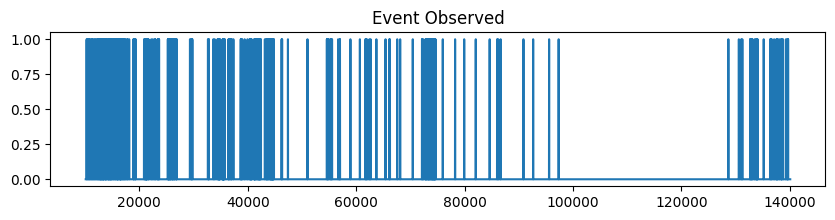

In [12]:
plt.figure(figsize=(10,2))
plt.plot(labels_train_binary.index,labels_train_binary['Label'])
plt.title('Event Observed')
plt.show()

# Drop non-event windows close to event windows

In [13]:
labels_train_binary.head()

,StartIndex,EndIndex,Label,Date,File
10100,0,600,0,20230703,DataRecordInput_2023073_141030.dat
10101,20,620,0,20230703,DataRecordInput_2023073_141030.dat
10102,40,640,0,20230703,DataRecordInput_2023073_141030.dat
10103,60,660,0,20230703,DataRecordInput_2023073_141030.dat
10104,80,680,0,20230703,DataRecordInput_2023073_141030.dat


In [14]:
event_idx_train_range_idx_collection=[]
for date in os.listdir(root):
    if '.xlsx' in date or '.ipynb_checkpoints' in date:continue                    #跳过标签文件和临时文件
    date_path=os.path.join(root,date)
    for file in tqdm.tqdm(os.listdir(date_path),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        if '.tgz' in file:continue                 #跳过tgz文件
        labels_train_binary_seg=labels_train_binary[labels_train_binary['File']==file]
        event_idx_train=np.array(labels_train_binary_seg[labels_train_binary_seg['Label']==1].index)
        if event_idx_train.shape[0]==0:continue
        #取上下150行(1.5s)为临近范围
        event_idx_train_range_start_index=event_idx_train-150
        event_idx_train_range_end_index=event_idx_train+150
        #Correct the min_max index to prevent cross-file window
        idx_lowerbound=labels_train_binary_seg.index.min()
        idx_upperbound=labels_train_binary_seg.index.max()
        event_idx_train_range_start_index[event_idx_train_range_start_index<idx_lowerbound]=idx_lowerbound
        event_idx_train_range_end_index[event_idx_train_range_end_index<idx_lowerbound]=idx_lowerbound
        event_idx_train_range_end_index[event_idx_train_range_end_index>idx_upperbound]=idx_upperbound
        event_idx_train_range_idx=np.unique(np.concatenate([
            list(range(start,end)) for start,end in zip(event_idx_train_range_start_index,event_idx_train_range_end_index)]))
        event_idx_train_range_idx_collection.append(event_idx_train_range_idx)
event_idx_train_range_idx_collection=np.concatenate(event_idx_train_range_idx_collection)
#Drop non-event window
print('Training set:\n')
labels_train_binary=labels_train_binary.loc[~((labels_train_binary.index.isin(event_idx_train_range_idx_collection))&(labels_train_binary['Label']==0)),:]
labels_train_binary['Label'].value_counts()

100%|██████████| 17/17 [00:00<00:00, 237.11it/s]                                                                                                               

丢弃后的训练数据集:



0    58499
1     8083
Name: Label, dtype: int64

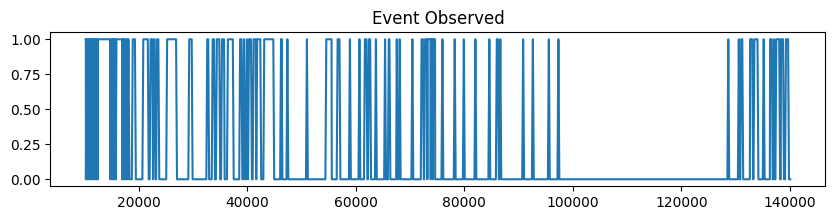

In [15]:
plt.figure(figsize=(10,2))
plt.plot(labels_train_binary.index,labels_train_binary['Label'])
plt.title('Event Observed')
plt.show()

# File-level scaling

In [17]:
from sklearn.preprocessing import StandardScaler
for date in data.keys():
    for file in tqdm.tqdm(data[date].keys(),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        standardscaler = StandardScaler()
        data[date][file]=pd.DataFrame(standardscaler.fit_transform(data[date][file]))

100%|██████████| 17/17 [00:00<00:00, 155.69it/s]                                                                                                               


# Batch Generator

In [18]:
labels_train_binary.head()

,StartIndex,EndIndex,Label,Date,File
10249,2980,3580,1,20230703,DataRecordInput_2023073_141030.dat
10250,3000,3600,1,20230703,DataRecordInput_2023073_141030.dat
10251,3020,3620,1,20230703,DataRecordInput_2023073_141030.dat
10252,3040,3640,1,20230703,DataRecordInput_2023073_141030.dat
10253,3060,3660,1,20230703,DataRecordInput_2023073_141030.dat


In [19]:
#标签乱序，用于后续generator随机抽取滑窗数据
from sklearn.utils import shuffle
labels_train_binary=shuffle(labels_train_binary,random_state=42)
labels_valid_binary=shuffle(labels_valid_binary,random_state=42)
labels_unlabeled_binary=shuffle(labels_unlabeled_binary,random_state=42)

In [20]:
"""训练batch/验证batch/测试batch通用，生成标注数据批量"""
"""传入labels_df如果只有0的部分，那么输出的batch全是无事件段，反之亦然"""
"""控制传入labels_df的行数，可以控制产生的总样本量"""
"""权重还是需要自己设"""
def batch_labeled_generator_Xy(labels_df,batchsize=128,balanced_weights=True):
    """
    Input:
        labels:pd.DataFrame, shuffled before put in
        balanced_weights:will assign balanced weights to 0-1 samples
    Output:
        (X_batch:np.array,y_batch:np.array[[int],[int],...]):tuple, length=batchsize
    """
    if balanced_weights:n_nonevents,n_events=labels_df['Label'].value_counts().sort_index()          #统计0样本和1样本的数目，用于计算权重
    labels_df_cp=labels_df.reset_index(drop=True)
    for i in range(0,labels_df_cp.shape[0]//batchsize*batchsize,batchsize):
        X_batch=[]
        y_batch=labels_df_cp['Label'].values[i:i+batchsize]
        labels_batch=labels_df_cp.iloc[i:i+batchsize,:].reset_index(drop=True)
        for j in range(labels_batch.shape[0]):
            date=labels_batch['Date'][j]
            file=labels_batch['File'][j]
            start_idx=labels_batch['StartIndex'][j]
            end_idx=labels_batch['EndIndex'][j] 
            X_batch.append(data[date][file].iloc[start_idx:end_idx,:])
        X_batch=np.stack(X_batch).reshape(batchsize,600,21,1)
        if balanced_weights: yield (X_batch,y_batch, np.array(list(map(lambda x:n_nonevents/labels_df.shape[0] if x else n_events/labels_df.shape[0],y_batch))))                 #设0-1样本的权重
        else: yield (X_batch,y_batch)

def batch_unlabeled_generator_Xy(labels_df,batchsize=128):
    """
    Input:
        labels:pd.DataFrame, shuffled before put in
    Output:
        (X_batch:np.array,y_batch:np.array[[int],[int],...]):tuple, length=batchsize
        #since X here are real samples, y are all -1, in order to implement wasserstein GAN
    """    
    labels_df_cp=labels_df.reset_index(drop=True)
    for i in range(0,labels_df_cp.shape[0]//batchsize*batchsize,batchsize):
        X_batch=[]
        y_batch=labels_df_cp['Label'].values[i:i+batchsize]
        labels_batch=labels_df_cp.iloc[i:i+batchsize,:].reset_index(drop=True)
        for j in range(labels_batch.shape[0]):
            date=labels_batch['Date'][j]
            file=labels_batch['File'][j]
            start_idx=labels_batch['StartIndex'][j]
            end_idx=labels_batch['EndIndex'][j] 
            X_batch.append(data[date][file].iloc[start_idx:end_idx,:])
        X_batch=np.stack(X_batch).reshape(batchsize,600,21,1)
        yield (X_batch,y_batch)

# Performance Benchmark

In [21]:
mode_benchmark=labels_train_binary['Label'].value_counts().max()/labels_train_binary.shape[0]
print('Acc训练性能基准值:',labels_train_binary['Label'].value_counts().max()/labels_train_binary.shape[0])
print('Acc验证性能基准值:',labels_valid_binary['Label'].value_counts().max()/labels_valid_binary.shape[0])

Acc训练性能基准值: 0.8786008230452675
Acc验证性能基准值: 0.9901058631921824


# Basic Modeling

In [22]:
from keras import models
from keras import layers
from keras import callbacks
from keras import optimizers
from keras import initializers
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model

batchsize=128
ncols=21

2023-09-26 17:02:44.316924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 17:02:44.838787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-26 17:02:44.838854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-26 17:02:44.838860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [23]:
tmp=batch_unlabeled_generator_Xy(labels_unlabeled_binary)
tmp=next(tmp)
tmp[0].shape

(128, 600, 21, 1)

In [24]:
def build_G(z_dim=(60,21)):
    """输出同shape的fake多维时序"""
    model = models.Sequential()
    #White noise inflation
    model.add(layers.BatchNormalization(input_shape=z_dim))
    model.add(layers.TimeDistributed(layers.Dense(21,)))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.BatchNormalization())
    #Time Series Generating
    model.add(layers.LSTM(21,activation='tanh',return_sequences=True))
    model.add(layers.LSTM(21,activation='tanh',return_sequences=True))
    model.add(layers.LSTM(21,activation='tanh',return_sequences=True))
    #Time Series Padding
    model.add(layers.Reshape((-1,21,1)))
    model.add(layers.Conv2DTranspose(1,kernel_size=(10,1),strides=(2,1),activation='tanh',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(1,kernel_size=(10,1),strides=(5,1),activation=None,padding='same'))
    return model
def build_D_net(input_shape=(600,21,1)):
    model = models.Sequential()
    #Time series Classifier
    model.add(layers.BatchNormalization(input_shape=input_shape))
    model.add(layers.Conv2D(1,kernel_size=(10,1),strides=(5,1),activation=None))
    model.add(layers.AveragePooling2D(pool_size=(2, 1), strides=(1,1)))
    model.add(layers.Reshape((-1,ncols)))
    model.add(layers.BatchNormalization())
    model.add(layers.LSTM(21,activation='tanh',return_sequences=True))
    model.add(layers.LSTM(21,activation='tanh',return_sequences=True))
    model.add(layers.LSTM(21,activation='tanh',return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(21)))
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    #Dimension Shrink
    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU(alpha=0.3))
    return model
def build_D_supervised(D_net):
    model = models.Sequential()
    model.add(D_net)
    model.add(layers.Dense(1,activation='sigmoid'))
    return model
def build_D_unsupervised(D_net):
    model = models.Sequential()
    model.add(D_net)
    model.add(layers.Dense(1,activation='sigmoid'))
    return model
def build_SGAN(G,D):
    model = models.Sequential()
    model.add(G)
    model.add(D)
    return model    

In [25]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
with tf.device('/CPU:3'):
    D_net = build_D_net()

    # Build & compile the Discriminator for supervised training
    D_supervised = build_D_supervised(D_net)
    D_supervised.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=optimizers.RMSprop(learning_rate=0.001))

    # Build & compile the Discriminator for unsupervised training
    D_unsupervised = build_D_unsupervised(D_net)
    D_unsupervised.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=optimizers.RMSprop(learning_rate=0.001))

    # Build the Generator
    G = build_G()

    # Keep Discriminator’s parameters constant for Generator training
    D_unsupervised.trainable = False

    # Build and compile GAN model with fixed Discriminator to train the Generator
    # Note that we are using the Discriminator version with unsupervised output
    gan = build_SGAN(G=G, D=D_unsupervised)
    gan.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.001),metrics=['accuracy'])

2023-09-26 17:03:19.660787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 17:03:22.833577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22294 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-09-26 17:03:22.834662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22294 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:25:00.0, compute capability: 8.6
2023-09-26 17:03:22.835554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/

In [26]:
d_losses_supervised_train = []              # supervised Epoch D Loss
d_losses_supervised_valid = []              # supervised Epoch D Loss
d_accs_supervised_train=[]                  # supervised Epoch D Acc
d_accs_supervised_valid=[]                  # supervised Epoch D Acc

d_losses_unsupervised_train=[]              # Unsupervised Epoch D Loss
d_accs_unsupervised_train=[]                # Unsupervised Epoch D Acc
g_losses=[]                                 # Unsupervised Epoch G Loss

iteration_checkpoints = []                  

def train(iterations, batch_size, sample_interval):

    # Labels for real images: all 1
    real = np.ones((batch_size, 1))
    # Labels for fake images: all 0
    fake = np.zeros((batch_size, 1))

    for iteration in tqdm.tqdm(range(iterations),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        
        iteration_checkpoints.append(iteration + 1)
        # -------------------------
        #  Train the Discriminator
        # -------------------------
        # Batch Generator of real samples
        Xy_labeled_gen_train=batch_labeled_generator_Xy(labels_train_binary)
        Xy_unlabeled_gen_train=batch_unlabeled_generator_Xy(labels_unlabeled_binary.reset_index(drop=True).iloc[:128000]) #只取1000个unlabel batch

        # Train on Labeled data
        d_loss_supervised_train=[]
        d_acc_supervised_train=[]
        for batch in Xy_labeled_gen_train:
            X,y,weight=batch
            d_loss_supervised_train_, d_acc_supervised_train_ = D_supervised.train_on_batch(X,y,weight)
            d_loss_supervised_train.append(d_loss_supervised_train_)
            d_acc_supervised_train.append(d_acc_supervised_train_)
        d_loss_supervised_train=np.mean(d_loss_supervised_train)         #epoch supervised D loss
        d_acc_supervised_train=np.mean(d_acc_supervised_train)          #epoch supervised D Acc                  
        d_losses_supervised_train.append(d_loss_supervised_train)
        d_accs_supervised_train.append(d_acc_supervised_train)
                                        
        #Unsupervised training
        d_loss_unsupervised_train=[]
        d_acc_unsupervised_train=[]
        for batch in Xy_unlabeled_gen_train: 
            # 无标签真样本判别器训练
            X,y=batch
            d_loss_unsupervised_train_real,d_acc_unsupervised_train_real=D_unsupervised.train_on_batch(X,y)  
            # Generate fake samples
            z = np.random.normal(0, 1, (batch_size, *z_dim))             
            gen_X = G.predict(z,verbose=0)
            gen_y= np.zeros((batch_size, 1))
            # Discriminator training on fake samples
            d_loss_unsupervised_train_fake, d_acc_unsupervised_train_fake= D_unsupervised.train_on_batch(gen_X, gen_y)
            d_loss_unsupervised_train_ = 0.5 * np.add(d_loss_unsupervised_train_real, d_loss_unsupervised_train_fake)      
            d_loss_unsupervised_train.append(d_loss_unsupervised_train_)
            d_acc_unsupervised_train.append((d_acc_unsupervised_train_real,d_acc_unsupervised_train_fake))
        d_loss_unsupervised_train=np.mean(d_loss_unsupervised_train)                                                  #epoch unsupervised D loss                                
        d_losses_unsupervised_train.append(d_loss_unsupervised_train)
        d_acc_unsupervised_train=np.mean(d_acc_unsupervised_train,axis=0)                                             #epoch unsupervised D Acc (real,fake)
        d_accs_unsupervised_train.append(d_acc_unsupervised_train)                                          
                                                                      
        #Evaluate on real samples
        d_loss_supervised_valid, d_acc_supervised_valid = D_supervised.evaluate(batch_labeled_generator_Xy(labels_valid_binary),verbose=0) #epoch supervised D loss and supervised D Acc
        d_losses_supervised_valid.append(d_loss_supervised_valid)
        d_accs_supervised_valid.append(d_acc_supervised_valid)
                                        
        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, *z_dim))
        gen_y= np.ones((batch_size, 1))                    #Fake sample with true label
        # Train Generator
        g_loss,_ = gan.train_on_batch(z, gen_y)              #epoch G loss
        g_losses.append(g_loss)
                                        
        if (iteration + 1) % sample_interval == 0:
            # Output training progress
            print(f"""D loss supervised train:{d_loss_supervised_train}, D acc train:{100 * d_acc_supervised_train},
                      D loss supervised validate:{d_loss_supervised_valid}, D acc validate:{100 * d_acc_supervised_valid},
            """)
                                        
# Set hyperparameters
iterations = 20
batch_size=128
z_dim=(60,21)
sample_interval = 20

# Train the SGAN for the specified number of iterations
with tf.device('/CPU:3'):
    train(iterations, batch_size, sample_interval)

  0%|          | 0/20 [00:00<?, ?it/s]                                                                                                                         2023-09-26 17:03:39.719639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-09-26 17:03:40.980088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 20/20 [1:16:44<00:00, 230.21s/it]                                                                                                             

D loss supervised train:0.007176268204416986, D acc train:99.4140625,
                      D loss supervised validate:0.11548444628715515, D acc validate:97.34947681427002,
            


In [28]:
#Save
name='Discriminator_SGAN_V1'
D_supervised.save(name)
print('Model Size:',os.path.getsize(name)/1048576,'MB')

INFO:tensorflow:Assets written to: Discriminator_SGAN_V1/assets


INFO:tensorflow:Assets written to: Discriminator_SGAN_V1/assets


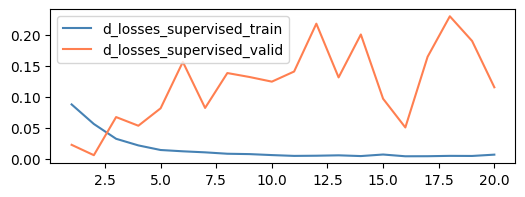

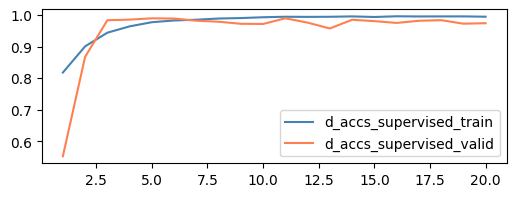

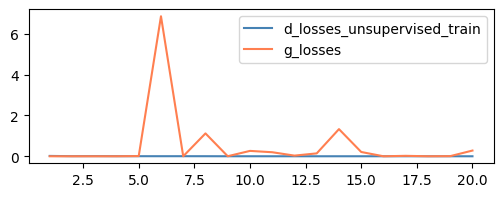

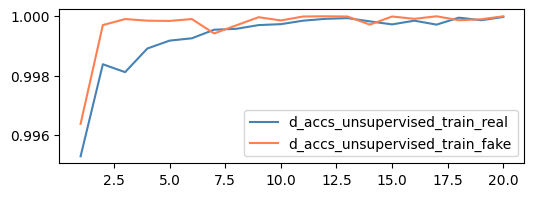

In [27]:
#Show training performance
d_accs_unsupervised_train_real,d_accs_unsupervised_train_fake=zip(*d_accs_unsupervised_train)

for curve1,curve2 in [('d_losses_supervised_train','d_losses_supervised_valid'),
                      ('d_accs_supervised_train','d_accs_supervised_valid'),
                      ('d_losses_unsupervised_train','g_losses'),
                      ('d_accs_unsupervised_train_real','d_accs_unsupervised_train_fake')
                     ]:
    epochs=list(range(1,21))
    plt.figure(figsize=(6,2))
    plt.plot(epochs,globals()[curve1],color='steelblue',label=curve1)
    plt.plot(epochs,globals()[curve2],color='coral',label=curve2)
    plt.legend()
    plt.show()

## Tuning Threshold

In [48]:
from sklearn.metrics import confusion_matrix,classification_report

In [29]:
#Load saved model
name='Discriminator_SGAN_V1'
model=models.load_model(name)

In [42]:
X_train=np.array([batch[0] for batch in batch_labeled_generator_Xy(labels_train_binary)]).reshape(-1,600,21,1)
y_train=np.array([batch[1] for batch in batch_labeled_generator_Xy(labels_train_binary)]).reshape(-1,1)

2084/2084 [==============================] - 15s 7ms/step


100%|██████████| 100/100 [00:00<00:00, 191.32it/s]                                                                                                                                                             


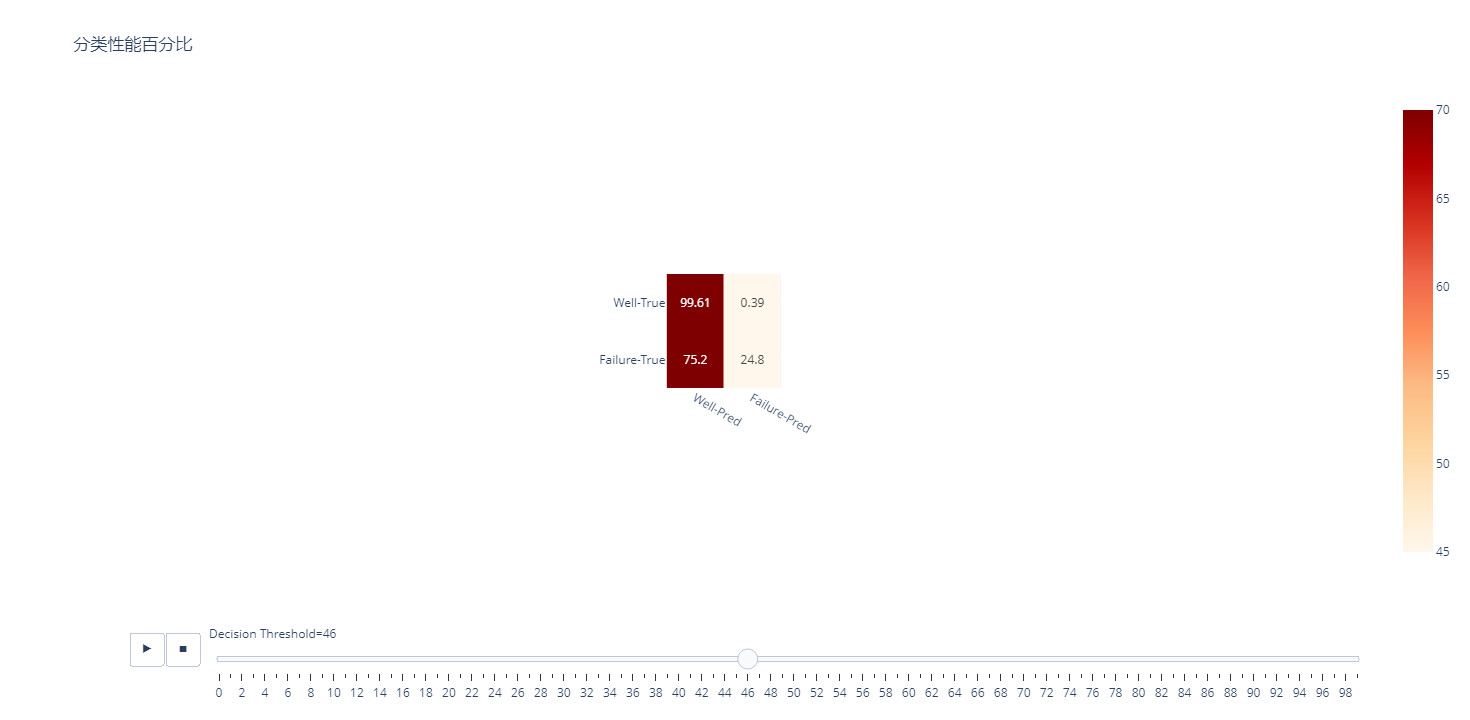

In [44]:
#Tuning Threshold

def threshold_viz(y_true,y_pred_probs):
    cms=[]
    for threshold in tqdm.tqdm(np.arange(0,1,0.01),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        cm=confusion_matrix(y_true,y_pred_probs>threshold)
        cm=np.round(np.array(list(map(lambda x:x/sum(x), cm))),4)*100
        cms.append(cm)

    fig=px.imshow(np.array(cms),animation_frame=0,
                  x=['Well-Pred','Failure-Pred'],y=['Well-True','Failure-True'],title='分类性能百分比',
                 zmin=45,zmax=70,text_auto=True,color_continuous_scale='OrRd')
    fig['layout']['sliders'][0]['currentvalue']['prefix']='Decision Threshold='
    fig.show()


y_train_pred_probs=model.predict(X_train)
threshold_viz(y_train,y_train_pred_probs)

In [46]:
#设定事件判定阈值
threshold=0.21

In [50]:
y_train_pred=y_train_pred_probs>threshold
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     61269
           1       0.83      0.26      0.40      5419

    accuracy                           0.94     66688
   macro avg       0.88      0.63      0.68     66688
weighted avg       0.93      0.94      0.92     66688



# Validate

In [51]:
X_valid=np.array([batch[0] for batch in batch_labeled_generator_Xy(labels_valid_binary)]).reshape(-1,600,21,1)
y_valid=np.array([batch[1] for batch in batch_labeled_generator_Xy(labels_valid_binary)]).reshape(-1,1)

In [52]:
y_valid_pred=model.predict(X_valid)>threshold
print(classification_report(y_valid,y_valid_pred))

cm=confusion_matrix(y_valid,y_valid_pred)
cm=pd.DataFrame(np.round(np.array(list(map(lambda x:x/sum(x), cm))),4)*100,
                index=['Well-True','Failure-True'],
                columns=['Well-Pred(%)','Failure-Pred(%)'])
cm

140/140 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4187
           1       0.12      0.03      0.04       293

    accuracy                           0.92      4480
   macro avg       0.53      0.51      0.50      4480
weighted avg       0.88      0.92      0.90      4480



,Well-Pred(%),Failure-Pred(%)
Well-True,98.61,1.39
Failure-True,97.27,2.73
